In [ ]:
+# PS7

In [ ]:
# Problem 1

In [14]:
# Installing lightcurve
! python -m pip install lightkurve --upgrade

In [36]:
# Imports 
import math
import scipy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.special import gammainc, gamma
from scipy.integrate import quad

In [16]:
# Problem 1
lcs = lk.search_lightcurve("Kepler-7b", mission="Kepler", cadence="short").download_all()
time_all = lcs[0].time.value # get the time of each observation
flux_all = np.array(lcs[0].flux.value.data) # get the flux
flux_err_all = np.array(lcs[0].flux_err.value.data) # get the error in the flux

# Ensures time, flux, and flux_err have same number of elements
assert(len(time_all)==len(flux_all) and len(flux_all)==len(flux_err_all))

In [20]:
# Extracting values in the time between t=261 and t=262 using a mask
mask = (time_all>=261) & (time_all<=262)
time_all = time_all[mask]
flux_all = flux_all[mask]
flux_err_all = flux_err_all[mask]

# Calculate average flux and standard deviation
average_flux_all = np.mean(flux_all)
average_flux_all

106457.66

In [21]:
np.std(flux_all)

287.75525

In [22]:
def exclude_transit(time, flux, flux_err, iterations=5):
    for _ in range(iterations):
        average_flux = np.mean(flux)
        sigma_flux = np.std(flux)

        # Creating a mask to exclude points more than 2σ away from the mean
        transit_mask = np.abs(flux - average_flux) / sigma_flux <= 2
        time = time[transit_mask]
        flux = flux[transit_mask]
        flux_err = flux_err[transit_mask]

    return time, flux, flux_err

time_filtered, flux_filtered, flux_err_filtered = exclude_transit(time_all, flux_all, flux_err_all)

In [23]:
print(time_filtered, flux_filtered, flux_err_filtered)

[261.00017066 261.00085173 261.00153281 ... 261.99729436 261.99865651
 261.99933759] [106560.03 106636.   106611.7  ... 106553.1  106520.72 106534.52] [51.94582  51.97515  52.025043 ... 52.033455 52.03526  52.04274 ]


In [71]:
# normalize flux and flux error
normalized_flux = flux_all / statistics.mean(flux_filtered)
normalized_flux_err = flux_err_all / statistics.mean(flux_err_filtered)

In [26]:
statistics.mean(flux_filtered)

106595.22

In [27]:
normalized_flux = flux_filtered/average_flux_filtered
print(normalized_flux)

[0.9996699 1.0003825 1.0001546 ... 0.9996049 0.9993011 0.9994306]


In [28]:
normalized_standard_deviation = flux_err_filtered/standard_deviation_flux_filtered
print(normalized_standard_deviation)

[0.9957896  0.99635184 0.99730825 ... 0.99746954 0.9975041  0.9976475 ]


<ErrorbarContainer object of 3 artists>

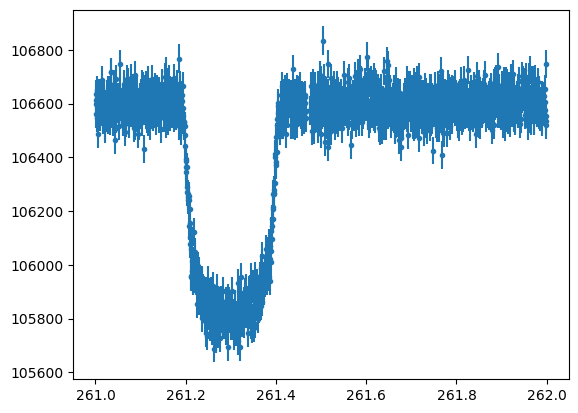

In [29]:
plt.errorbar(time_all, flux_all, yerr=flux_err_all, label='Observed Data', fmt='.')

In [30]:
# Simpsons integral approximation
"""
This function takes the following imputs:
f: the integrand
x0: lower limit of integral
xn: upper limit of integral
n: number of different subintervals

delta_x: the width of each subinterval

This function uses parabolas to create an approximation of an integral
"""
def approximate_int_simpsons(f, x0, xn, n):
    delta_x = (xn - x0) / n
    simpsons_approx = 0
    
    for i in range(n):
        xi = x0 + i * delta_x
        xi1 = x0 + (i + 1) * delta_x
        simpsons_approx += (f(xi) +  4*f((xi + xi1) / 2) + f(xi1)) * delta_x / 6
        
    return simpsons_approx


In [31]:
def lambda_function(p, z):
    if 1 + p < z:
        y = 0
    elif math.fabs(1-p) < z and z <= 1 + p:
        k0 = math.acos((p**2+z**2-1)/(2*p*z))
        k1 = math.acos((1-p**2+z**2)/(2*z))
        y = (p**2 * k0 + k1 - math.sqrt((4*z**2 - (1+z**2-p**2)**2)/4))/math.pi
    elif z <= 1-p:
        y = p**2
    elif z <= p-1:
        y = 1

    return y

def flux_function(p, z):
    return 1 - lambda_function(p, math.fabs(z))

In [34]:
# Function calculate F_theoretical
def calculate_F_theoretical(p, t0, tau, time_all, average_flux_filtered):
    z = (time_all - t0) / tau
    u = (1 - r**2)**0.5
    calc_i = u(r)**0.5
    
    def integrand_numerator(r):
        return np.array([calc_i(r) * flux_function(p, z_val) * 2 * r for z_val in z])
    
    def integrand_denominator(r):
        return np.array([calc_i(r) * 2 * r for _ in z])
    
    numerator = np.array([approximate_int_simpsons(lambda r: integrand_numerator(r)[i], 0, 1, 100) for i in range(len(z))])
    denominator = np.array([approximate_int_simpsons(lambda r: integrand_denominator(r)[i], 0, 1, 100) for i in range(len(z))])

    F_theoretical = numerator / denominator
    F_theoretical *= average_flux_filtered

    return F_theoretical
    

In [43]:
"""
p = 0.0775
t0 = 261.3
tau = 0.1
z = (time_all-t0)/tau
u = lambda r: (1 - r**2)**0.5
calc_i = lambda r: u(r)**0.5

    
# Function has an integral in both the numerator and denominator, so they will be computed indidual
def integrand_numerator(r):
    result = np.array([calc_i(r) * flux_function(p, z_val) * 2 * r for z_val in z])
    return result

numerator =([approximate_int_simpsons(lambda r: integrand_numerator(r)[i], 0, 1, 100) for i in range(len(z))])

def integrand_denominator(r):
    result1 = np.array([calc_i(r) * 2 * r for z_val in z])
    return result1

denominator = ([approximate_int_simpsons(lambda r: integrand_denominator(r)[i], 0, 1, 100) for i in range(len(z))])

unobscured_flux = average_flux_filtered

numerator = np.array(numerator)
denominator = np.array(denominator)
F_theoretical = numerator / denominator

F_theoretical *= unobscured_flux

print (F_theoretical)
"""


'\np = 0.0775\nt0 = 261.3\ntau = 0.1\nz = (time_all-t0)/tau\nu = lambda r: (1 - r**2)**0.5\ncalc_i = lambda r: u(r)**0.5\n\n    \n# Function has an integral in both the numerator and denominator, so they will be computed indidual\ndef integrand_numerator(r):\n    result = np.array([calc_i(r) * flux_function(p, z_val) * 2 * r for z_val in z])\n    return result\n\nnumerator =([approximate_int_simpsons(lambda r: integrand_numerator(r)[i], 0, 1, 100) for i in range(len(z))])\n\ndef integrand_denominator(r):\n    result1 = np.array([calc_i(r) * 2 * r for z_val in z])\n    return result1\n\ndenominator = ([approximate_int_simpsons(lambda r: integrand_denominator(r)[i], 0, 1, 100) for i in range(len(z))])\n\nunobscured_flux = average_flux_filtered\n\nnumerator = np.array(numerator)\ndenominator = np.array(denominator)\nF_theoretical = numerator / denominator\n\nF_theoretical *= unobscured_flux\n\nprint (F_theoretical)\n'

In [47]:
p = 0.0775
t0 = 261.3
tau = 0.1
z = (time_all - t0) / tau
#u = (1 - r**2)**0.5
#calc_i = u(r)**0.5

def integrand_numerator(r, z_val):
    return ((1 - r**2)**0.5)**0.5 * flux_function(p, z_val) * 2 * r

def integrand_denominator(r):
    return ((1 - r**2)**0.5)**0.5 * 2 * r

numerator_results = []
denominator_result, _ = quad(integrand_denominator, 0, 1) 

for z_val in z:
    result, _ = quad(integrand_numerator, 0, 1, args=(z_val,))
    numerator_results.append(result)

numerator = np.array(numerator_results)
F_theoretical = numerator / denominator_result  

unobscured_flux = average_flux_filtered

F_theoretical *= unobscured_flux

print(F_theoretical)


[106595.21875 106595.21875 106595.21875 ... 106595.21875 106595.21875
 106595.21875]


In [53]:
# Limb darkening 
def calc_i(r):
    u = math.sqrt((1-r**2))
    i = u**0.5
    return i

# Delta function is within F(p, |z|)
def delta_function(p, r, z):
    if r >= z + p or r <= z -p:
        return 0
    elif r + z <= p:
        return 1
    else:
        return math.pi**(-1)*math.acos((z**2 - p**2 + r**2)/(2*r*z))

# Function has an integral in both the numerator and denominator, so they will be computed indidual
def integrand_numerator(r):
    return calc_i(r)*(1 - delta_function(p, r, z))*2*r

#Computation of the integral in the denominator
def integrand_denominator(r):
    return calc_i(r)*2*r

f_theoretical_limb_darkening = []
z = (time_all-t0)/tau
for _z_val in z:
    # set the instance of z to the global z to be used in the functions
    z = abs(z)
    f_pz = approximate_int_simpsons(integrand_numerator, 0, 1, 100)/approximate_int_simpsons(integrand_denominator, 0, 1, 100)
    f_theoretical_limb_darkening.append(unobscured_flux*f_pz)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [86]:
# F theoretical including limb darkening
def predicted_flux(z, p):
    
    def limb_darkening_relation(r):
        return (1 - r**2)**(1/4)

    def delta_function(r, p, z):
        z = math.fabs(z)
        if r >= (z + p) or r <= (z - p): delta_value = 0  
        elif (r + z) <= p              : delta_value = 1 
        else                           : delta_value = math.acos((z**2 - p**2 + r**2)/(2 * z * r)) / math.pi
        return delta_value
    
    def flux_numerator(r):
        flux_numerator_value = limb_darkening_relation(r) * (1 - delta_function(r, p, z)) * 2 * r
        return flux_numerator_value
    
    def flux_denominator(r):
        flux_denominator_value = limb_darkening_relation(r) * 2 * r
        return flux_denominator_value
    
    lowerLim, upperLim = 0, 1
    integralOne, _ = scipy.integrate.quad(flux_numerator,   lowerLim, upperLim)
    integralTwo, _ = scipy.integrate.quad(flux_denominator, lowerLim, upperLim)
    flux_value = integralOne / integralTwo
    return flux_value

def make_z_array(time, t0, tau):
    z_array = (time - t0) / tau
    return z_array

def make_flux_predictions(z_array, p):
    flux_predictions = []
    for z in z_array:
        flux_prediction = predicted_flux(z, p)
        flux_predictions.append(flux_prediction)
    return np.array(flux_predictions)

In [87]:
z_array = make_z_array(time_all, t0, tau)
flux_predictions = make_flux_predictions(z_array, p)

In [35]:
len(F_theoretical)
len(flux_all)

1456

In [45]:
# Compute chi squared
chi_squared = np.sum(((flux_all - F_theoretical)/np.std(flux_all))**2)
print (chi_squared)

102.51234935366892


In [88]:
chi_squared = np.sum(((normalized_flux - flux_predictions)/np.std(flux_filtered))**2)
print (chi_squared)

1.998802960211614e-07


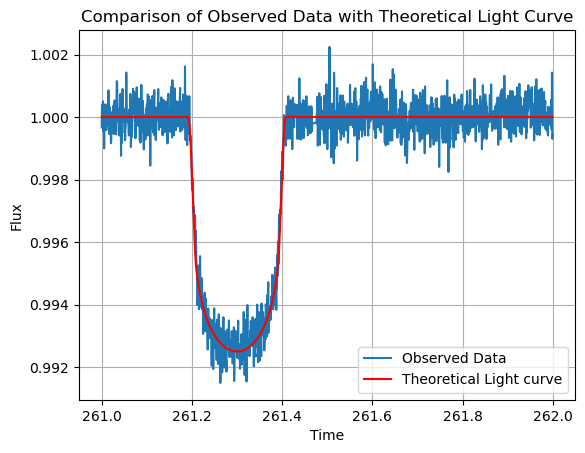

In [76]:
# Problem 2

#Plotting observed vs theoretical data
plt.figure
plt.plot(time_all, normalized_flux, label='Observed Data')
plt.plot(time_all, flux_predictions, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
I would say that this is a very good fit. Nearly perfect.
"""

In [85]:
# Compute liklihood of chi-squared value 
N = len(time_all)
M = 3
nu = N - M

p_value = gammainc(nu / 2, chi_squared / 2)
p_value

0.0

In [ ]:
"""
This is a very low p value and indicates that the model works very well. The probability that the given data was due to random chance is low.
"""

In [21]:
# Function calculate F_theoretical
def calculate_F_theoretical(p, t0, tau, time_filtered, average_flux_filtered):
    z = (time_filtered - t0) / tau
    u = lambda r: (1 - r**2)**0.5
    calc_i = lambda r: u(r)**0.5
    
    def integrand_numerator(r):
        return np.array([calc_i(r) * flux_function(p, z_val) * 2 * r for z_val in z])
    
    def integrand_denominator(r):
        return np.array([calc_i(r) * 2 * r for _ in z])
    
    numerator = np.array([approximate_int_simpsons(lambda r: integrand_numerator(r)[i], 0, 1, 100) for i in range(len(z))])
    denominator = np.array([approximate_int_simpsons(lambda r: integrand_denominator(r)[i], 0, 1, 100) for i in range(len(z))])

    F_theoretical = numerator / denominator
    F_theoretical *= average_flux_filtered

    return F_theoretical
    

In [89]:
def make_flux_prediction(time, t0, tau, p):
    z_array = (time - t0) / tau
    flux_predictions = []
    for z in z_array:
        flux_prediction = predicted_flux(z, p)
        flux_predictions.append(flux_prediction)
    return np.array(flux_predictions)

In [111]:
# Problem 3
tau_values = np.arange(0.08, 0.13, 0.001)
chi_squared_values = []

for tau in tau_values:
    flux_predictions = make_flux_prediction(time_all, t0, tau, p)
    
    chi_squared = np.sum(((normalized_flux - flux_predictions) / np.std(flux_filtered)) ** 2)
    chi_squared_values.append(chi_squared)
print(chi_squared_values)    
chi_squared_values = np.array(chi_squared_values)

min_chi_squared = np.min(chi_squared_values)
best_tau = tau_values[np.argmin(chi_squared_values)]
print (min_chi_squared, best_tau)

C:\Users\julia\AppData\Local\Temp\ipykernel_19776\3873036732.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integralOne, _ = scipy.integrate.quad(flux_numerator,   lowerLim, upperLim)


[9.114990202703158e-07, 8.539120979566359e-07, 7.973838945094957e-07, 7.417352511665562e-07, 6.871047158366082e-07, 6.33724823227102e-07, 5.818768658937537e-07, 5.318959218282112e-07, 4.842838562800173e-07, 4.3917187114231053e-07, 3.969544813753719e-07, 3.5799499361048306e-07, 3.226933346116186e-07, 2.913162810621202e-07, 2.641401932971075e-07, 2.414894593207201e-07, 2.2352207960738938e-07, 2.103483518716061e-07, 2.020203829196312e-07, 1.9855866062738948e-07, 1.9988029602116172e-07, 2.0579293571287394e-07, 2.1604483464591094e-07, 2.3057407570791294e-07, 2.491174999921256e-07, 2.7145882733998473e-07, 2.973732585424669e-07, 3.2654949801054e-07, 3.5886594165788666e-07, 3.9405385310910437e-07, 4.317756081714982e-07, 4.7170682525649667e-07, 5.136833984662407e-07, 5.574844648734839e-07, 6.029037170136151e-07, 6.496635561868158e-07, 6.977651548182478e-07, 7.471700932462227e-07, 7.977847495612425e-07, 8.494830951735803e-07, 9.022817791468903e-07, 9.560340588575869e-07, 1.0106691505516357e-06, 

In [101]:
flux_best_fit = make_flux_prediction(time_all, t0, 0.0999999999999999, p)

array([1., 1., 1., ..., 1., 1., 1.])

In [24]:
# Plot 
F_theoretical_best_fit = calculate_F_theoretical(p, t0, 0.08, time_filtered, average_flux_filtered)

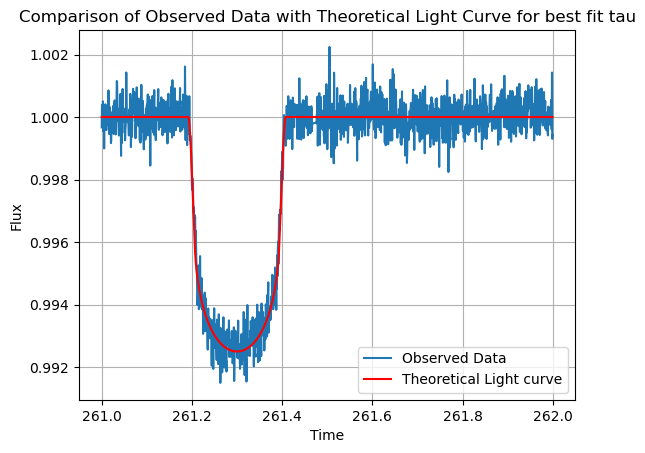

In [105]:
plt.figure
plt.plot(time_all, normalized_flux, label='Observed Data')
plt.plot(time_all, flux_best_fit, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve for best fit tau')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
# Calculate p value for best fit tau
p_value_best_fit = gammainc(nu / 2, min_chi_squared / 2)
p_value_best_fit

0.0

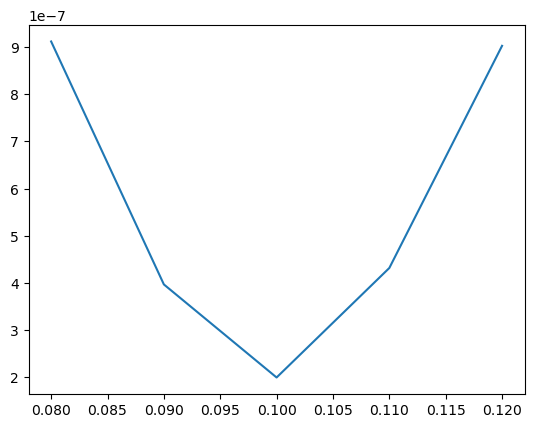

In [109]:
# Plot chi_squared figure
plt.plot(tau_values, chi_squared_values, label="Chi Squared Plot")

In [110]:
np.std(chi_squared_values)

2.87423211335213e-07